# W207 Final Project - House Prices

### Gerard, Jacques, Lucy and Saurav


## Introduction

Kaggle project: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

The objective of this project is to predict the sale price of homes in Ames, IA with maximum accuracy. Accuracy is evaluated on the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

The dataset contains attributes of each house and neighborhood, ranging from the roof material to the proximity to the railroad. Our team used random forest, gradient boosting, neural network, and linear regression methods to achieve a prediction accuracy of XX%.

## Setup

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [87]:
# Import packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import copy





In [88]:
# Load in the data
d = pd.read_csv('train.csv')
train_data_with_sp=copy.deepcopy(d)



In [ ]:
labels = d['SalePrice']
train_data = d.drop('SalePrice', axis=1) 


## Exploratory Data Analysis and Feature Engineering

### Data Structure

The training data contains 1460 examples with 81 features including house sale-price (labels).

The testing data contains 1459 examples, with 80 features (no sale-price labels).

Due to the absence of testing data labels, the accuracy of predictions cannot be assessed using this data until they are submitted to kaggle. We will make use of splits in the training data in order to explore the performance of predictive models.

In [3]:
# Examine the train labels
print(train_data.shape)
print(labels.shape)

(1460, 80)
(1460,)


In [4]:
labels.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

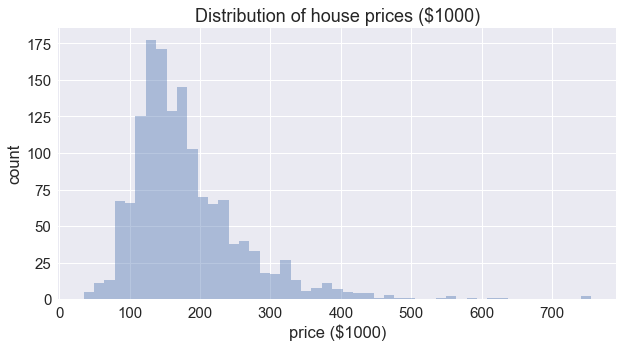

In [5]:
# Plot a histogram of the labels
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5)  
sns.distplot(labels/1000, kde = False)
plt.xlabel("price ($1000)")
plt.ylabel("count")
plt.title("Distribution of house prices ($1000)")
plt.show()

We see that the train labels are lognormally skewed. While the distribution shape will not affect all prediction methods, this should be kept in mind when performing linear regression.

In [6]:
# Examine the train data
# there are 1460 examples each with 81 features, including prices (training labels), 
# which have not been removed yet
print(train_data.shape)
train_data.head()

(1460, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
# Examine the data type for each feature
print(train_data.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


There are a large number of missing (NA) values, especially for certain features. While some of these reflect missing information, others reflect the absence of a particular feature (e.g. Alley). 

In [8]:
# Identify columns with NA values and display count of NAs:
for col in train_data:
    na_count = len(train_data[train_data[col].isnull()][col])
    if na_count > 0:
        print(col,' : ', na_count)

LotFrontage  :  259
Alley  :  1369
MasVnrType  :  8
MasVnrArea  :  8
BsmtQual  :  37
BsmtCond  :  37
BsmtExposure  :  38
BsmtFinType1  :  37
BsmtFinType2  :  38
Electrical  :  1
FireplaceQu  :  690
GarageType  :  81
GarageYrBlt  :  81
GarageFinish  :  81
GarageQual  :  81
GarageCond  :  81
PoolQC  :  1453
Fence  :  1179
MiscFeature  :  1406


Before determining how to deal with missing values, we conduct a univariate EDA of categorical and numerical features, as distinguished by data type. 

In [9]:
# Identify categorical features
train_data_cat = train_data.select_dtypes(include=['object'])
print(list(train_data_cat))
Ncat = train_data_cat.shape[1]
print(Ncat)
nullcat = []
for col in train_data_cat:
    na_count = len(train_data_cat[train_data[col].isnull()][col])
    if na_count > 0:
        nullcat.append(col)
print(nullcat)
print(len(nullcat))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
43
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
16


There are 43 categorical features, 16 of which contain NA values.
Where "NA" represents the absence of a property feature (e.g. basement, garage), the NA value is converted to a "None".
This is the case for all except the "Electrical" feature (which contains only one missing value).

In [10]:
nullcat.remove("Electrical")
train_data[nullcat] = train_data[nullcat].fillna("None")
train_data_cat = train_data.select_dtypes(include=['object'])

In [11]:
# Identify numerical features
train_data_num = train_data.select_dtypes(include=['int64','float64'])
print(list(train_data_num))
Nnum = train_data_num.shape[1]
print(Nnum)
nullnum = []
for col in train_data_num:
    na_count = len(train_data_num[train_data[col].isnull()][col])
    if na_count > 0:
        nullnum.append(col)
print(nullnum)
print(len(nullnum))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
37
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
3


There are 38 numeric features, 3 of which contain missing values. One of the missing values is Lot Frontage (linear feet of street connected to property) for which an NA corresponds to a value of 0. Another is MasVnrArea (Masonry veneer area in square feet) for which an NA also corresponds to a value of 0. The third is GarageYrBlt (year garage was built) for which an NA indicates the absence of a garage on the property (as with the categorical variables relating to garages). We remove the GarageYrBlt feature and the ID feature.

In [12]:
nullnum.remove("GarageYrBlt")
train_data[nullnum] = train_data[nullnum].fillna(0)
train_data = train_data.drop("Id", axis = 1)
train_data = train_data.drop("GarageYrBlt", axis = 1)
train_data_num = train_data.select_dtypes(include=['int64','float64'])

In [13]:
# Preprocessing to rescale the data. We will us MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

col_train = list(train_data_num.columns)
col_train_bis = list(train_data_num.columns)


mat_train = np.matrix(train_data_num)
mat_new = np.matrix(train_data_num)
mat_y = np.array(labels).reshape((1460,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_data_num_prepro = pd.DataFrame(prepro.transform(mat_train),columns = col_train)


### Categorial features

We graph each of the 43 categorical features...

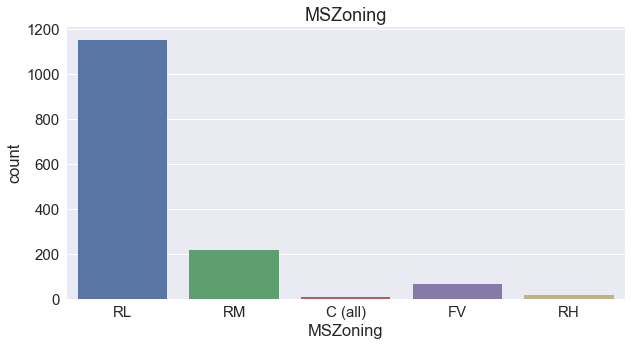

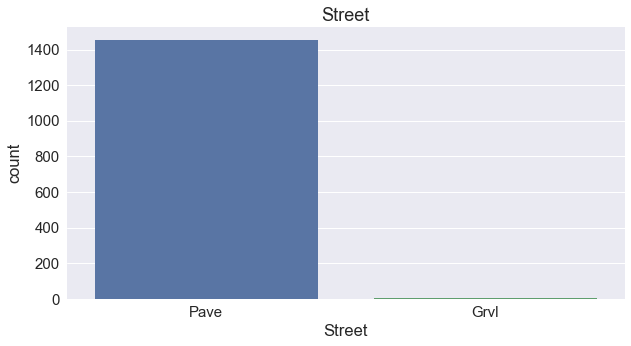

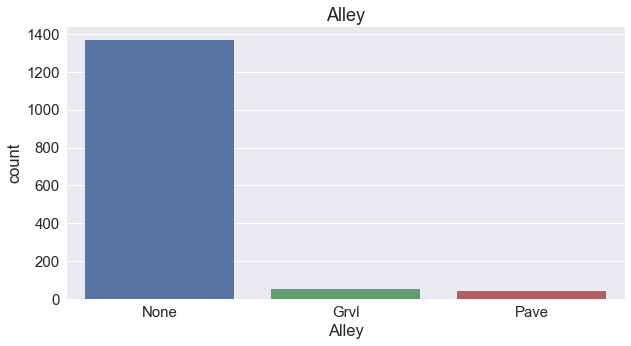

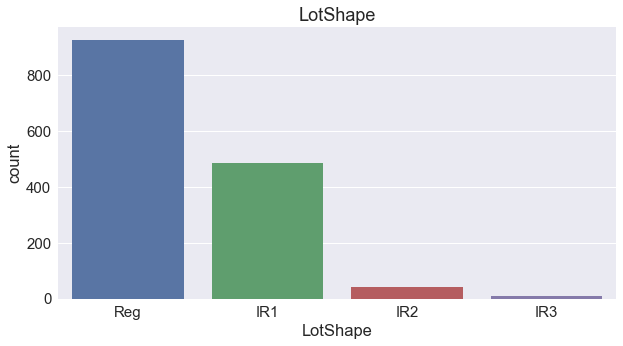

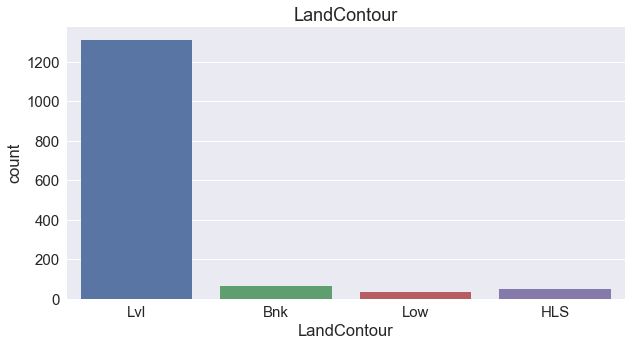

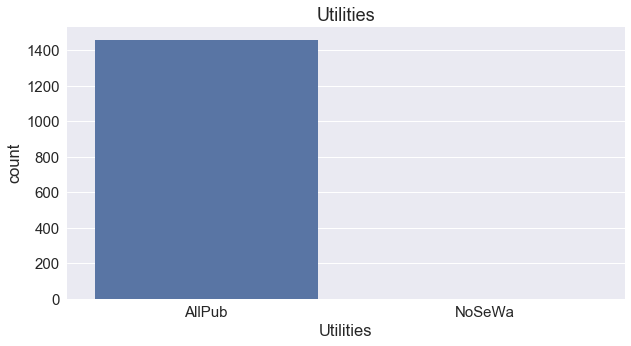

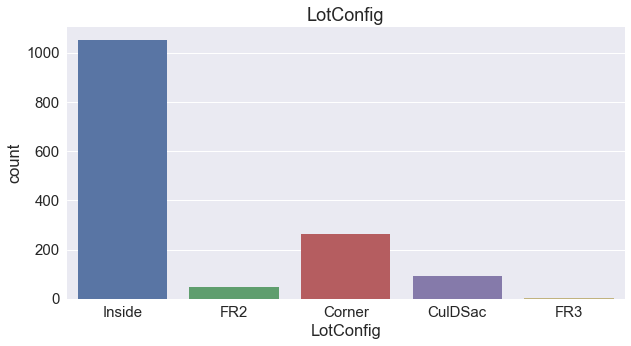

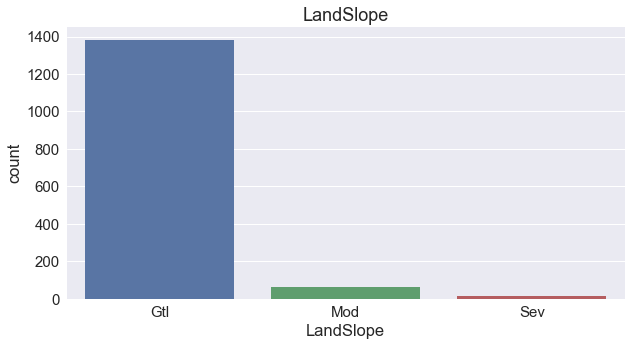

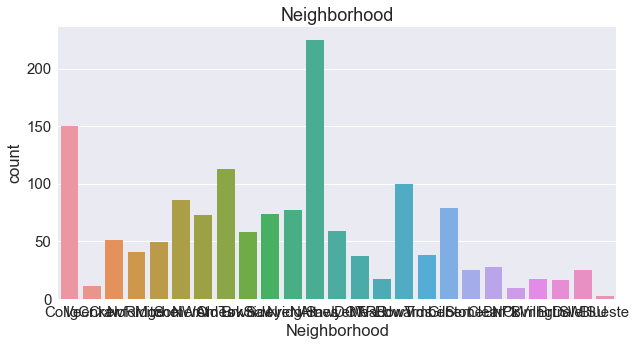

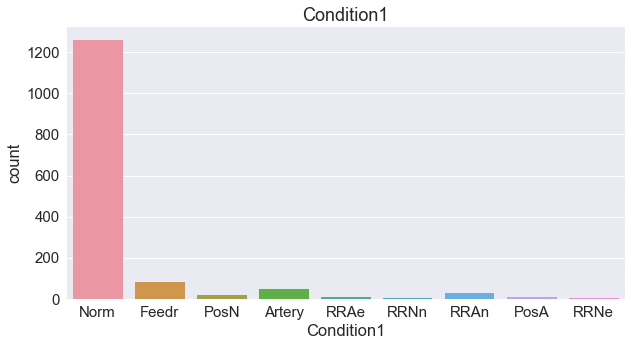

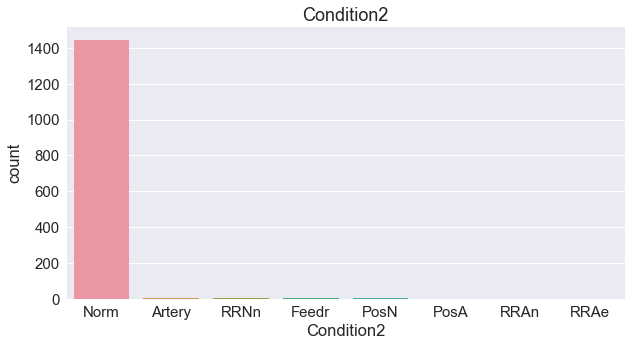

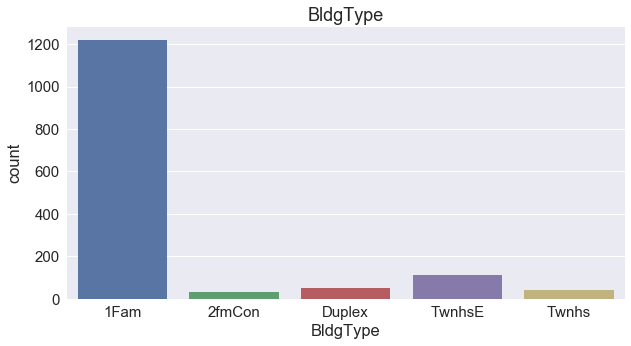

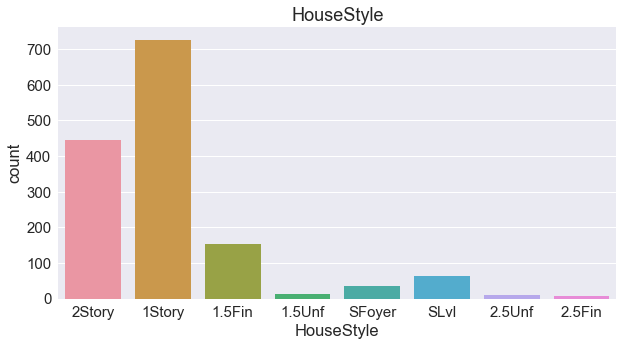

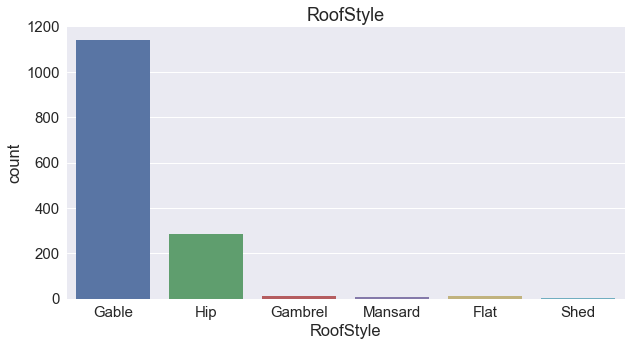

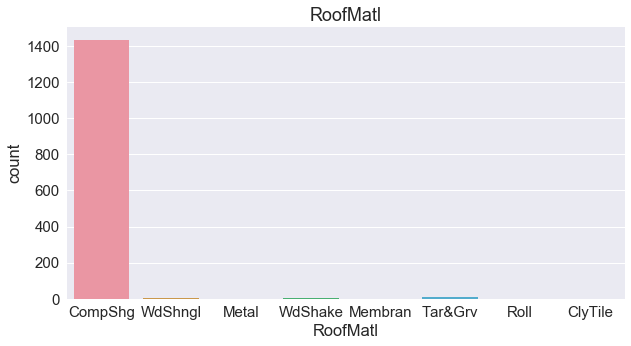

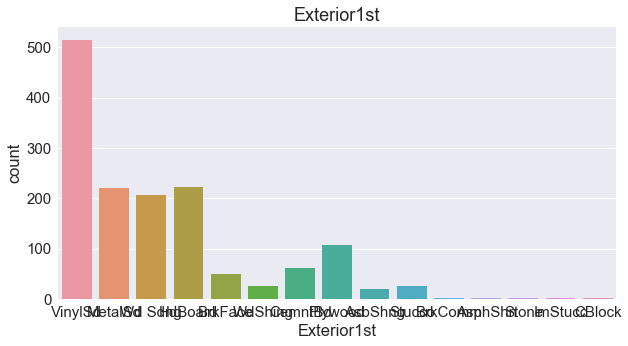

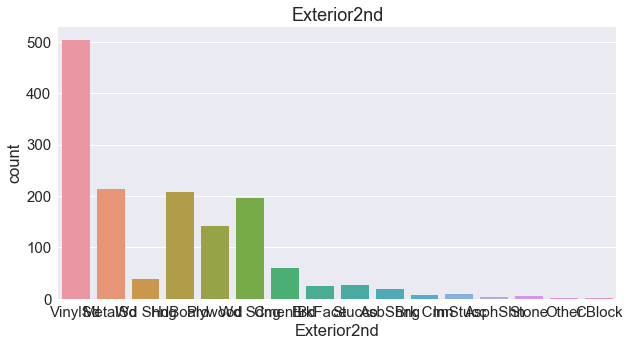

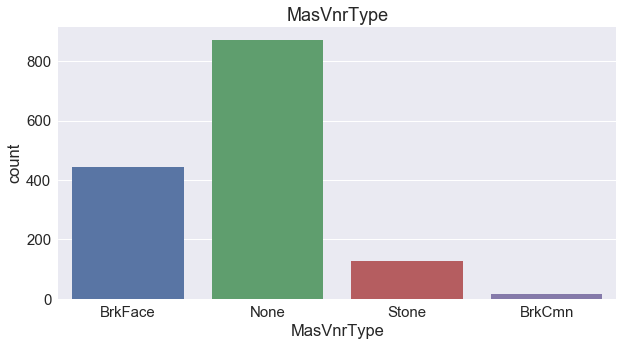

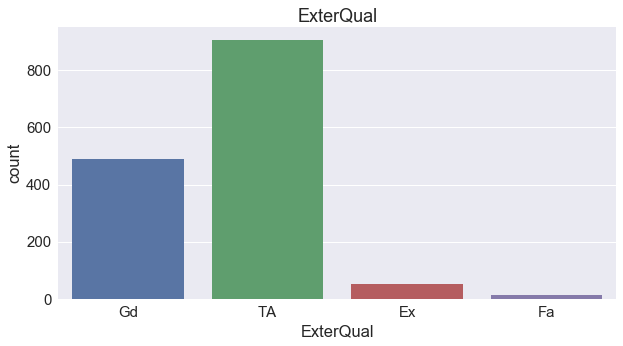

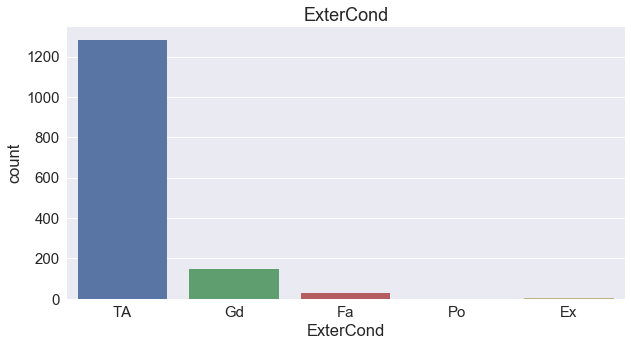

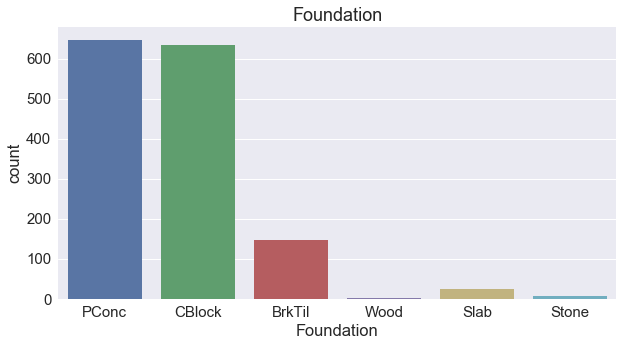

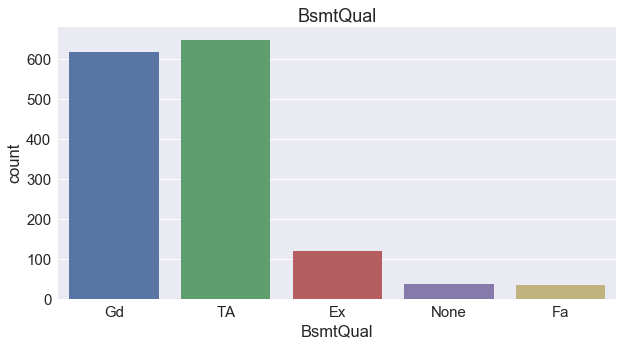

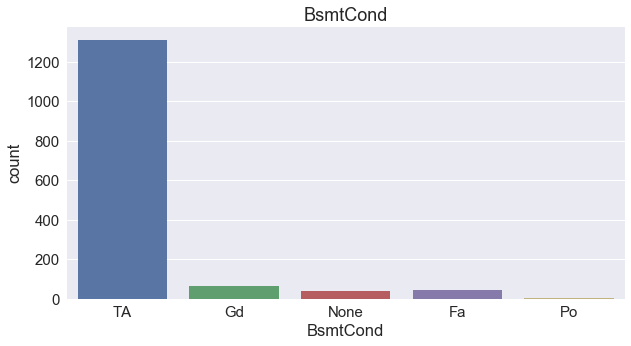

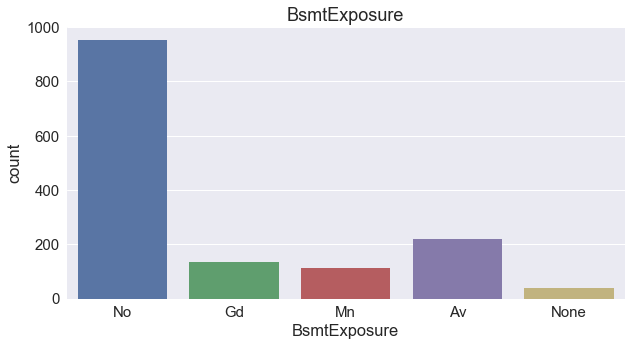

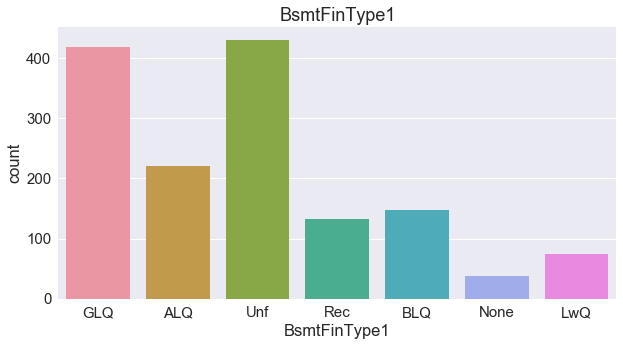

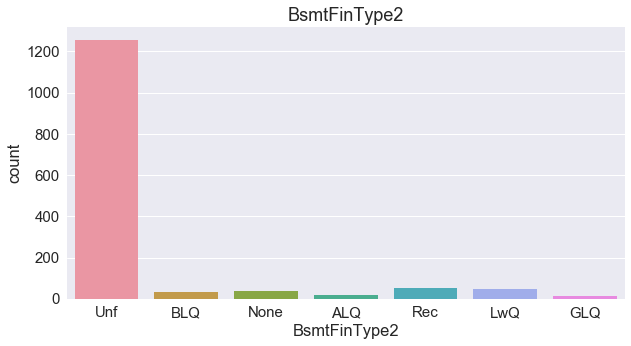

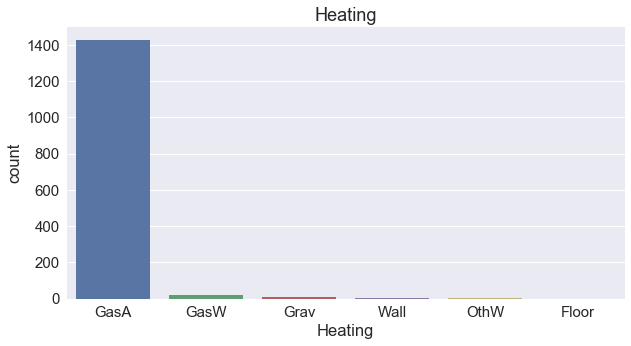

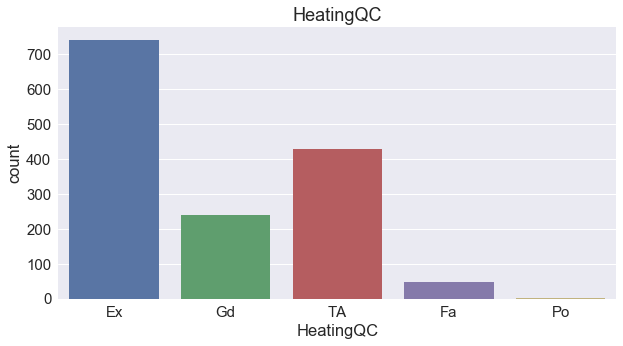

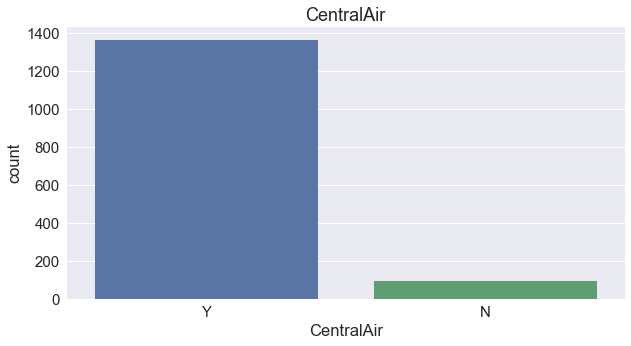

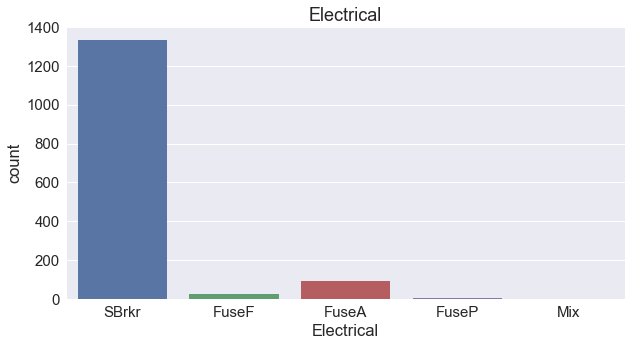

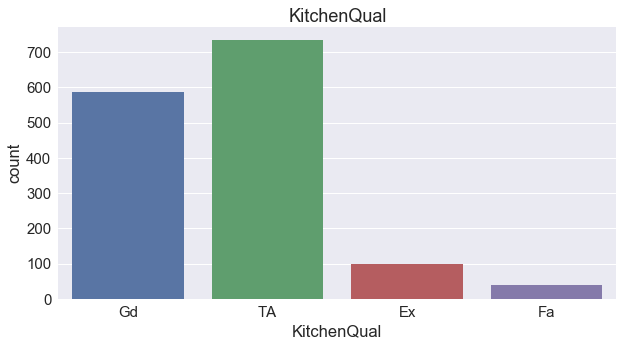

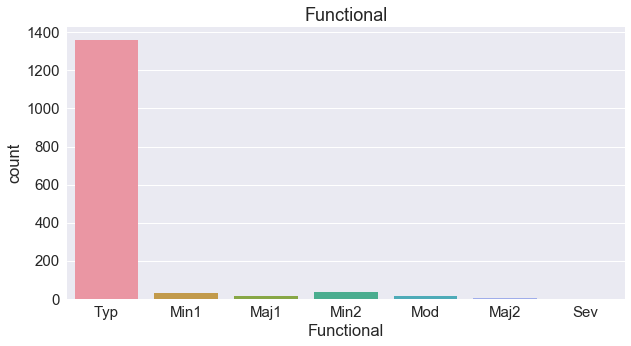

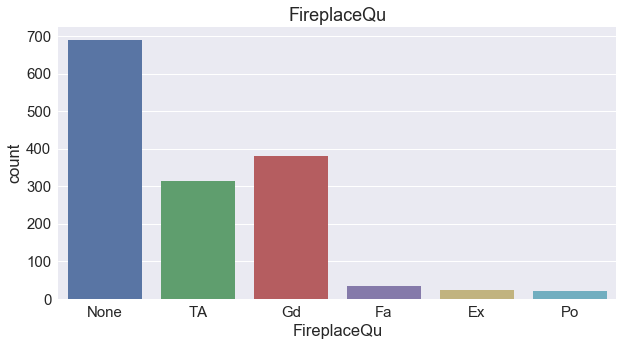

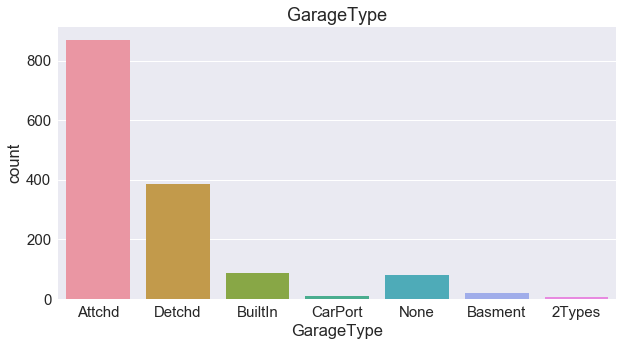

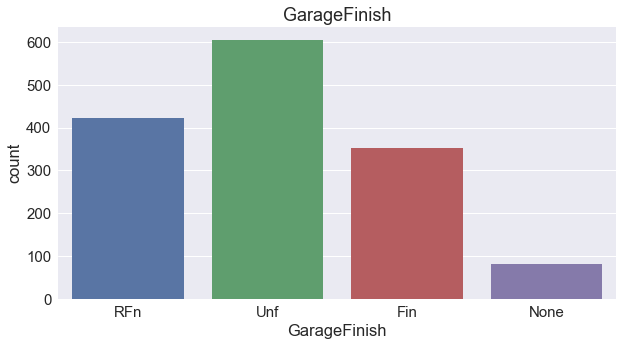

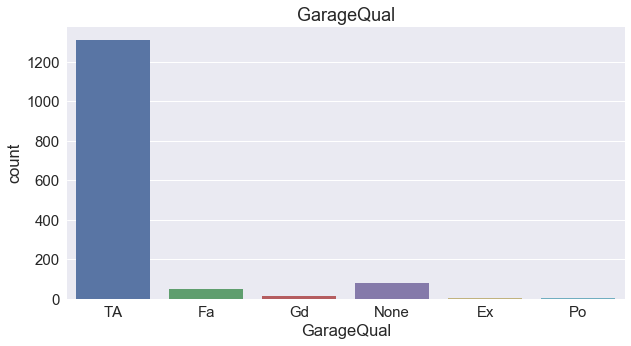

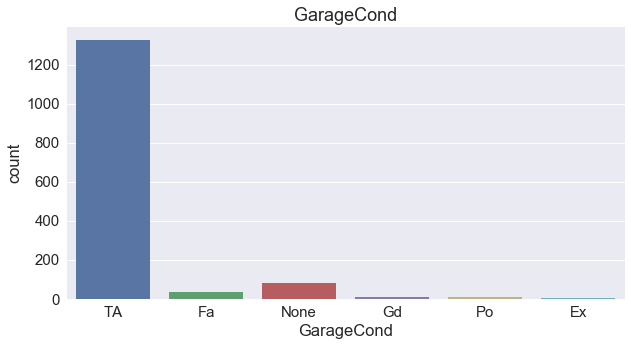

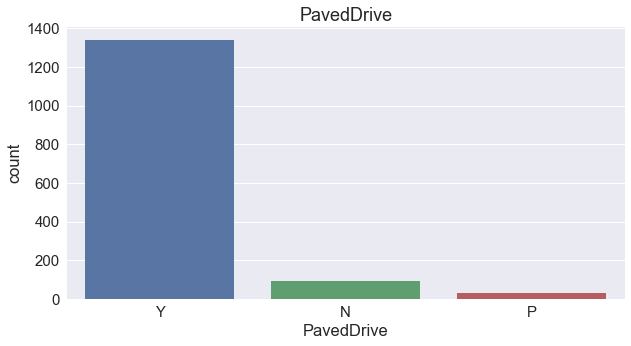

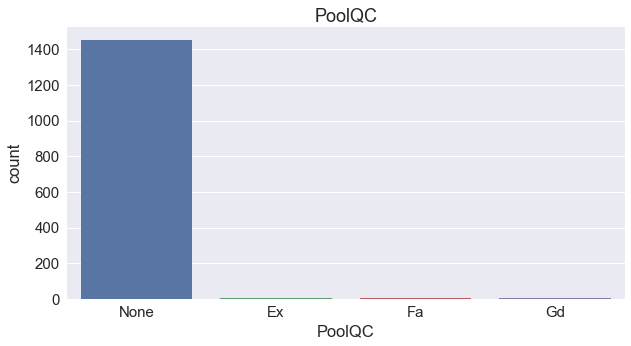

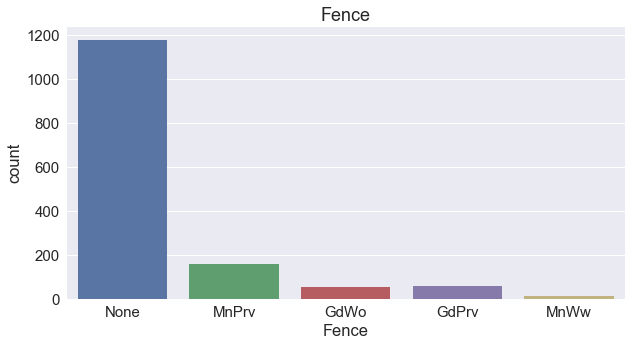

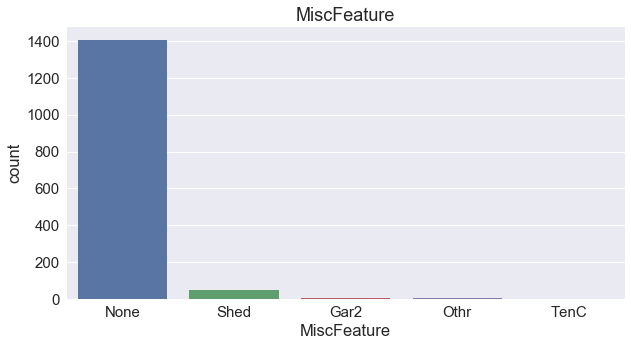

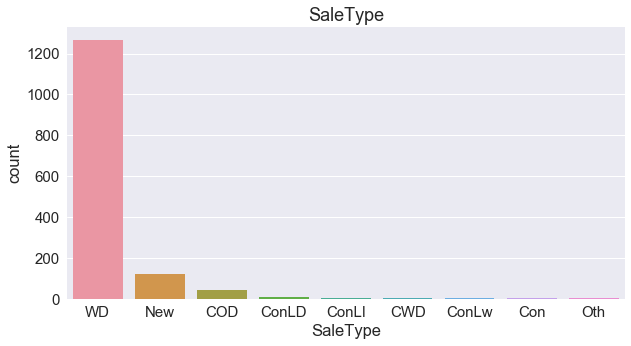

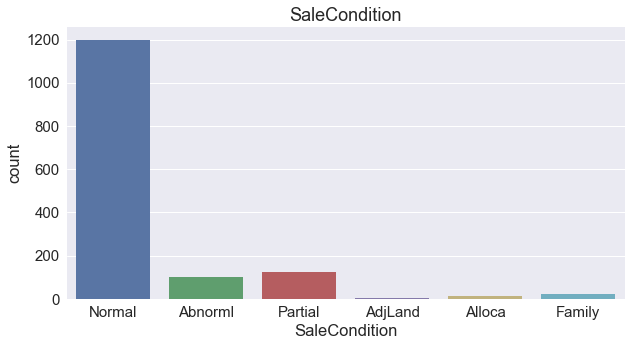

In [14]:
# Graph each of the categorical features
for i in train_data_cat:
    plt.figure(figsize=(10, 5)) 
    sns.countplot(train_data_cat[i])
    plt.title(i)
    plt.show()

... and take their value counts

In [15]:
for c in list(train_data_cat):
    print(c)
    print(train_data_cat[c].value_counts())
    print('\n')

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


Street
Pave    1454
Grvl       6
Name: Street, dtype: int64


Alley
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64


LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       

In order to use these categorical features in machine learning models, they must be converted into numerical features. This can be done by creating binary dummy features (one-hot-encoding), although where the categories are ordinal they can be converted into a rank number. 

Variables to be dropped will be added to the list drop_cols.

Ordinal variables will be added to the list ord_cols.

Other variables to be one-shot-encoded will be transformed using the dataframe replace() method and a suitable dictionary.

In [16]:
drop_cols = []
enc_cols = []

The categorical features are:

* MSZoning: Identifies the general zoning classification of the sale.
(values only for RL, RM, C, FV and RH: 4 dummies)
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
       


In [17]:
enc_cols.append("MSZoning")

* Street: Type of road access to property. There are so few gravel examples (only 6) that this variable can be dropped.

       Grvl	Gravel	
       Pave	Paved

In [18]:
drop_cols.append("Street")

* Alley: Type of alley access to property. This can be converted to an ordinal variable.

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access


In [19]:
train_data["Alley"] = train_data["Alley"].replace({"None": 0, "Grvl": 1, "Pave": 2})

* LotShape: General shape of property. This can also become an ordinal variable, combining IR2 and IR3 due to the small number of examples in each.
    
       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

In [20]:
train_data["LotShape"] = train_data["LotShape"].replace({"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 2})

* LandContour: Flatness of the property. Most observations are "Lvl" with a few in the other categories. Can be transformed into a binary level/non-level variable. 

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

In [21]:
train_data["LandContour"] = train_data["LandContour"].replace({"Lvl": 0, "Bnk": 1, "HLS": 1, "Low": 1})

* Utilities: Type of utilities available. All AllPub, so delete this variable
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	

In [22]:
drop_cols.append("Utilities")

* LotConfig: Lot configuration. One-shot-encoding, but combine FR2 and FR3 due to the small number of FR3 examples.

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

In [23]:
train_data["LotConfig"] = train_data["LotConfig"].replace({"FR3": "FR2"})
enc_cols.append("LotConfig")

* LandSlope: Slope of property. Either gentle, moderate or severe, but so few severe that this variable can be treated as a binary gentle/non-gentle.
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

In [24]:
train_data["LandSlope"].replace({"Gtl": 0, "Mod": 1, "Sev" : 1});
enc_cols.append("LandSlope")

* Neighborhood: Physical locations within Ames city limits. Although it may be possible to group these this would require too much work, so we create use one-shot-encoding for all neighborhoods.

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

In [25]:
enc_cols.append("Neighborhood")

* Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
* Condition2: Proximity to various conditions (if more than one is present)
Can be combined with Condition1 as a single binarized variable

       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

In [26]:
enc_cols.append("Condition1")
enc_cols.append("Condition2")

* BldgType: Type of dwelling. One-shot-encoding.
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

In [27]:
enc_cols.append("BldgType")

* HouseStyle: Style of dwelling. Combine 1.5Fin and 1.5Unf, and combine 2.5Unf and 2.5Fin
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

In [28]:
train_data["HouseStyle"] = train_data["HouseStyle"].replace({"1.5Unf": "1.5Fin", "2.5Unf": "2.5Fin"});
enc_cols.append("HouseStyle")

* RoofStyle: Type of roof (very few apart from Gable and Hip). Encode as Gable, Hip and Other.

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

In [29]:
train_data["RoofStyle"] = train_data["RoofStyle"].replace({"Gambrel": "Other", 
                                     "Mansard": "Other",
                                    "Flat": "Other",
                                    "Shed": "Other"});
enc_cols.append("RoofStyle")

* RoofMatl: Roof material. Delete this variable as almost all CompShg

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

In [30]:
drop_cols.append("RoofMatl")

* Exterior1st: Exterior covering on house (can be combined with Exterior2nd with one-shot-encoding). Some categories have very few observations...

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
* Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [31]:
enc_cols.append("Exterior1st")
enc_cols.append("Exterior2nd")

* MasVnrType: Masonry veneer type. One-shot-encode, but combine BrkComn with BrkFace.

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

In [32]:
train_data["MasVnrType"] = train_data["MasVnrType"].replace({"BrkCmn": "BrkFace"});
enc_cols.append("MasVnrType")

* ExterQual: Evaluates the quality of the material on the exterior (ORDINAL)
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [33]:
train_data["ExterQual"] = train_data["ExterQual"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* ExterCond: Evaluates the present condition of the material on the exterior (ORDINAL)
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [34]:
train_data["ExterCond"] = train_data["ExterCond"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5})

* Foundation: Type of foundation (combine Wood, Slab and Stone into 'other' and one-shot-encode)
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

In [35]:
train_data["Foundation"] = train_data["Foundation"].replace({"Wood":"Other", 
                                      "Slab":"Other", "Stone":"Other"});
enc_cols.append("Foundation")

* BsmtQual: Evaluates the height of the basement (ORDINAL)

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [36]:
train_data["BsmtQual"] = train_data["BsmtQual"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* BsmtCond: Evaluates the general condition of the basement (ORDINAL)

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

In [37]:
train_data["BsmtCond"] = train_data["BsmtCond"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* BsmtExposure: Refers to walkout or garden level walls (ORDINAL)

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

In [38]:
train_data["BsmtExposure"] = train_data["BsmtExposure"].replace({"None": 0, "No": 1, "Mn": 2, 
                                     "Av": 3, "Gd": 4});

* BsmtFinType1: Rating of basement finished area (ORDINAL)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
        
* BsmtFinType2: Rating of basement finished area (if multiple types) - Drop this one as it's all mostly Unf

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [39]:
train_data["BsmtFinType1"] = train_data["BsmtFinType1"].replace({"None": 0, "Unf": 1, "LwQ": 2, 
                                     "Rec": 3, "BLQ": 4, "ALQ": 5, 
                                       "GLQ": 6});
drop_cols.append("BsmtFinType2")

* Heating: Type of heating; remove - almost all GasA, heatingQC more relevant.
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

In [40]:
drop_cols.append("Heating")

* HeatingQC: Heating quality and condition (ORDINAL)

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [41]:
train_data["HeatingQC"] = train_data["HeatingQC"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* CentralAir: Central air conditioning (make binary)

       N	No
       Y	Yes

In [42]:
train_data["CentralAir"] = train_data["CentralAir"].replace({"N": 0, "Y": 1});

* Electrical: Electrical system (mostly all SBrkr) - should drop this (which will also remove the remaining NA value)

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [43]:
drop_cols.append("Electrical")

* KitchenQual: Kitchen quality (ORDINAL)

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [44]:
train_data["KitchenQual"] = train_data["KitchenQual"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* Functional: Home functionality (Assume typical unless deductions are warranted ORDINAL)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [45]:
train_data["Functional"] = train_data["Functional"].replace({"Typ": 0, "Min1": 1, "Min2": 2, 
                                     "Mod": 3, "Maj1": 4, "Maj2": 5,
                                     "Sev": 6, "Sal":7});

* FireplaceQu: Fireplace quality (ORDINAL)

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace


In [46]:
train_data["FireplaceQu"] = train_data["FireplaceQu"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

In [47]:
enc_cols.append("GarageType")

* GarageFinish: Interior finish of the garage (ORDINAL)

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [48]:
train_data["GarageFinish"] = train_data["GarageFinish"].replace({"None": 0, "Unf": 1, "RFn": 2, 
                                     "Fin": 3});

* GarageQual: Garage quality (ORDINAL; almost all TA)

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [49]:
train_data["GarageQual"] = train_data["GarageQual"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* GarageCond: Garage condition (ORDINAL)

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [50]:
train_data["GarageCond"] = train_data["GarageCond"].replace({"None": 0, "Po": 1, "Fa": 2, 
                                     "TA": 3, "Gd": 4, "Ex": 5});

* PavedDrive: Paved driveway (ORDINAL)

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

In [51]:
train_data["PavedDrive"] = train_data["PavedDrive"].replace({"N": 0, "P": 1, "Y": 2});

* PoolQC: Pool quality - drop as almost all 'none' (and there is a pool area numeric variable anyway)
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [52]:
drop_cols.append("PoolQC")

* Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence


In [53]:
train_data["Fence"] = train_data["Fence"].replace({"None": 0, "MnWw": 1, "GdWo": 2,
                                "MnPrv": 3, "GdPrv": 4});

* MiscFeature: Miscellaneous feature not covered in other categories. Almost all 'none'. Change into none, shed and other.
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None


In [54]:
train_data["MiscFeature"]= train_data["MiscFeature"].replace({"TenC": "Othr", 
                                       "Gar2": "Oth", "Elev": "Oth"});
enc_cols.append("MiscFeature")

* SaleType: Type of sale (very few other than WD, New or COD, combine the rest into other).
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

In [55]:
train_data["SaleType"] = train_data["SaleType"].replace({"ConLD": "Othr", 
                                    "ConLI": "Oth", 
                                    "CWD": "Oth",
                                    "ConLw":"Oth",
                                    "Con":"Oth"});
enc_cols.append("SaleType")

* SaleCondition: Condition of sale. One-shot-encoding.

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

In [56]:
enc_cols.append("SaleCondition")

Seven features will be dropped; Street, Utilities, RoofMatl, BsmtFinType2, Heating, Electrical, PoolQC

In [57]:
drop_cols

['Street',
 'Utilities',
 'RoofMatl',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'PoolQC']

In [58]:
# remove these features
train_data = train_data.drop(drop_cols, axis = 1);

Fifteen features will be converted using one-shot-encoding; MSZoning, LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, GarageType, MiscFeature, SaleType, SaleCondition

In [59]:
enc_cols

['MSZoning',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [60]:
# change categorical variables to numeric variables using one-shot-encoding
# for N categories only N-1 dummies are needed

for c in enc_cols:
    value_set = set(train_data[c].values)
    value_set.remove(list(value_set)[0])
    for v in value_set:
        new_col = c + '_' + v.replace(' ', '_')
        train_data[new_col] = train_data[c].map(lambda x: 1.0 if x==v else 0.0)
train_data = train_data.drop(enc_cols, axis=1)


In [61]:
list(train_data)

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'LandContour',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_C_(all)',
 'MSZoning_FV',
 'MSZoning_RM',
 'MSZoning_RL',
 'LotConfig_Corner',
 'LotConfig_Inside',
 'LotConfig_CulDSac',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_CollgCr',
 'Neighborh

### Numerical Features

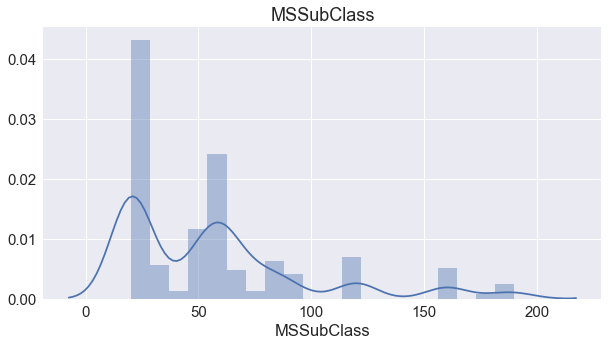

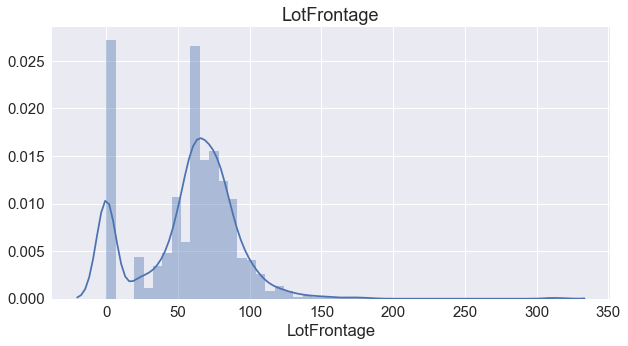

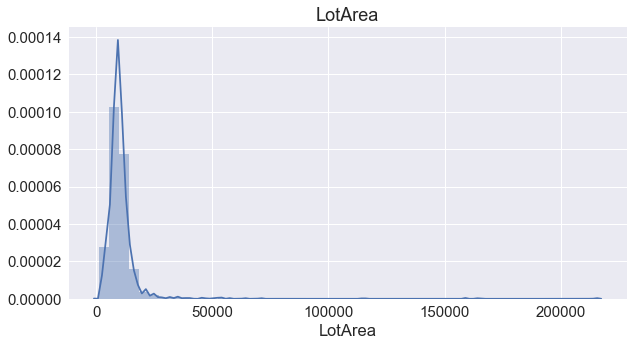

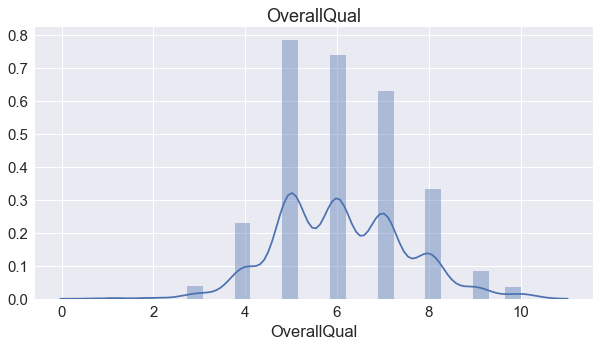

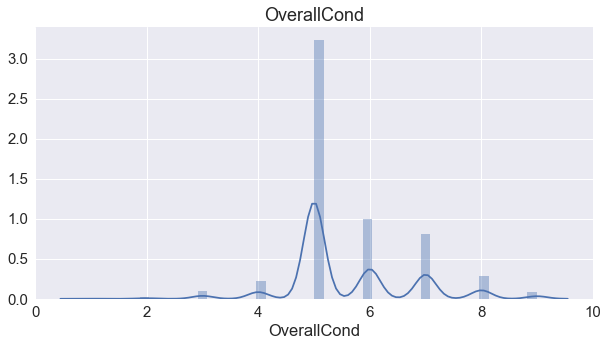

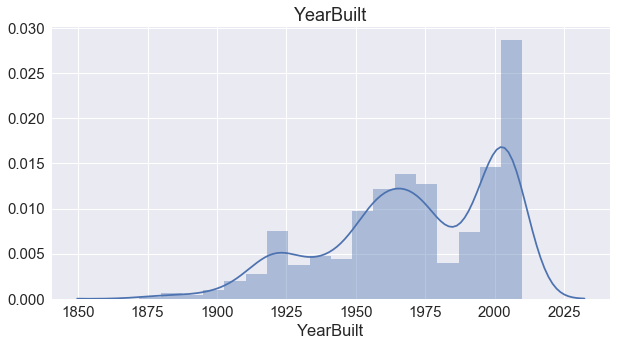

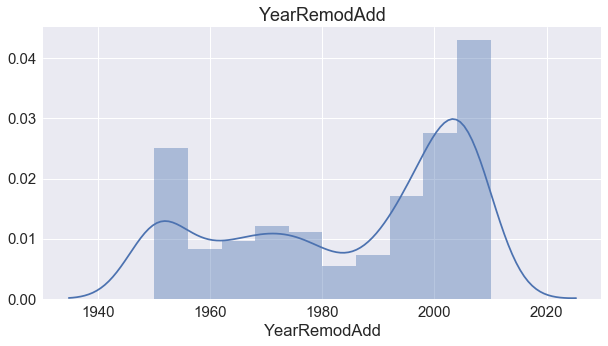

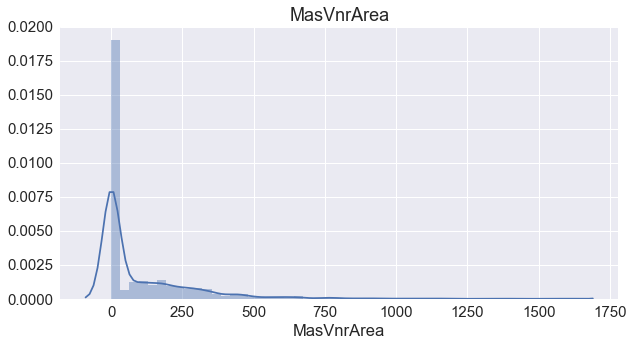

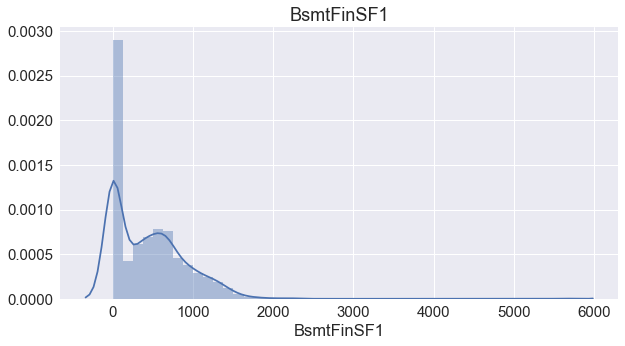

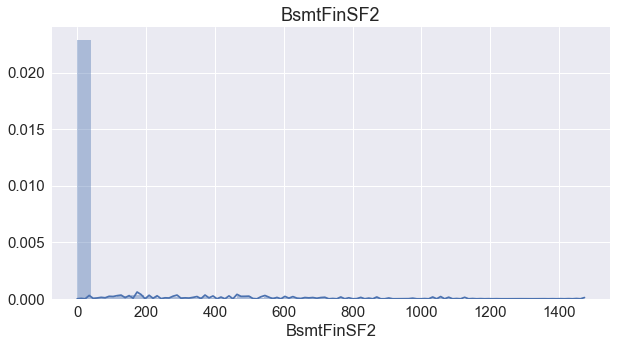

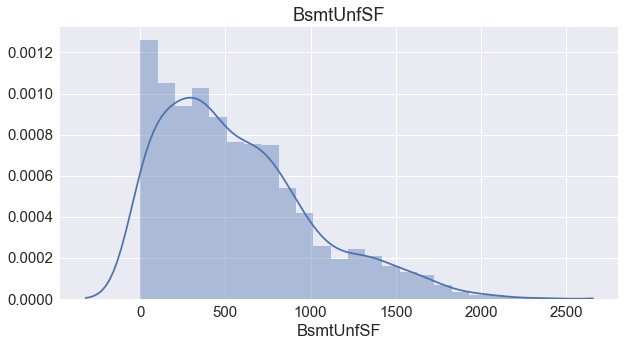

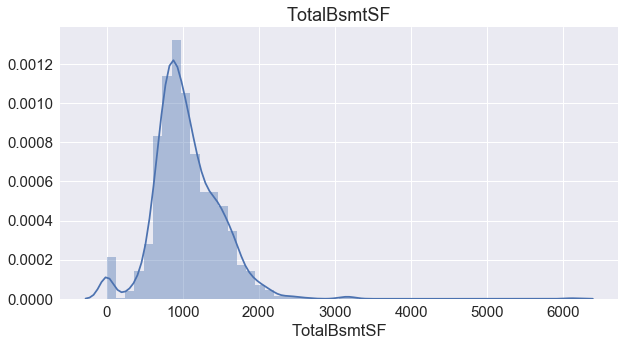

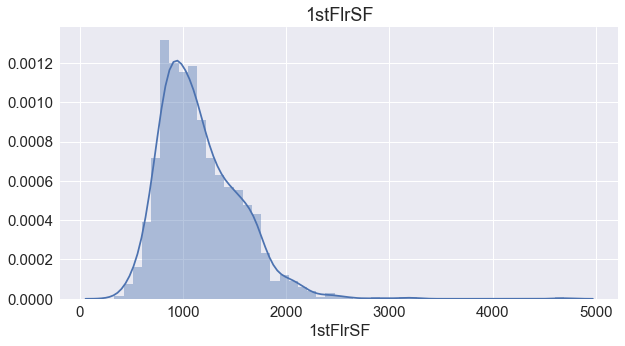

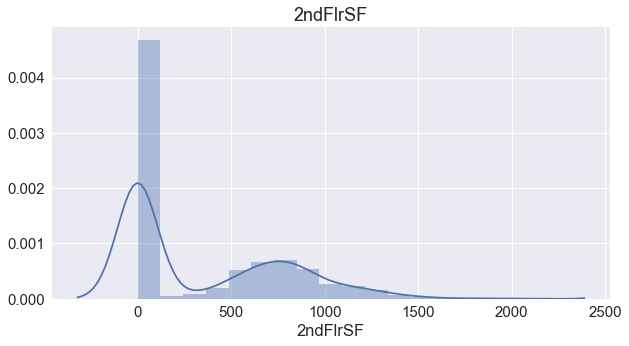

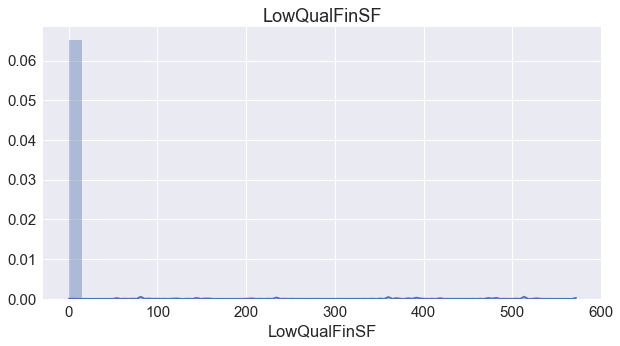

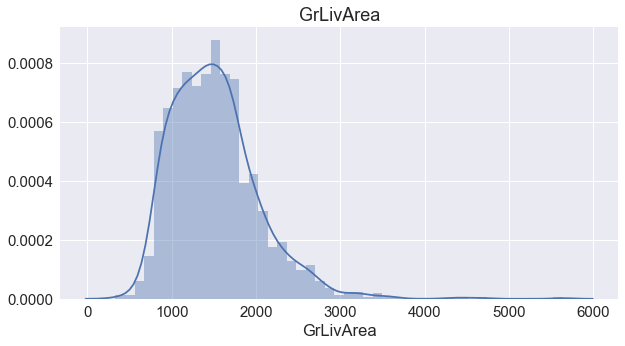

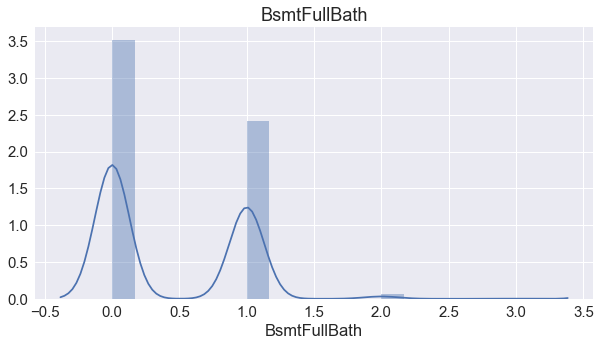

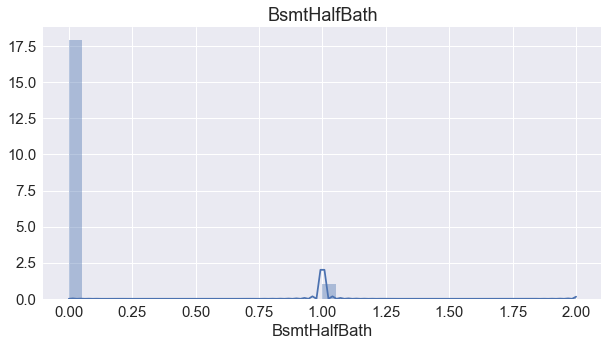

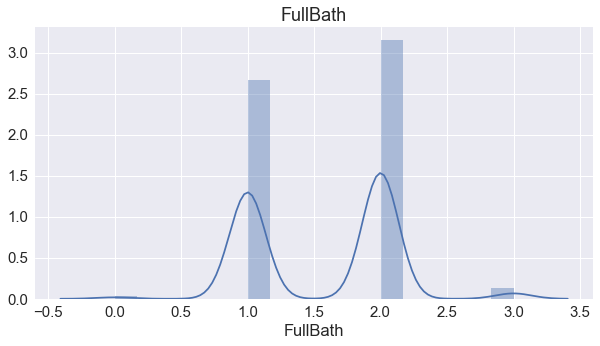

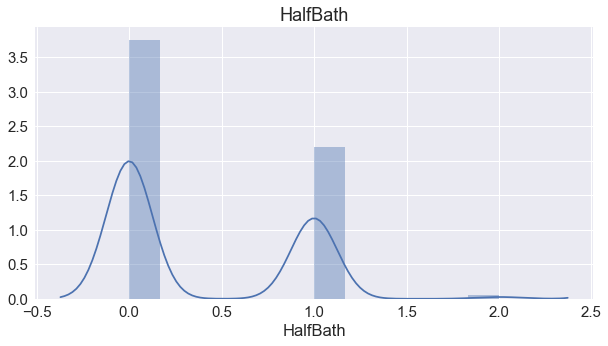

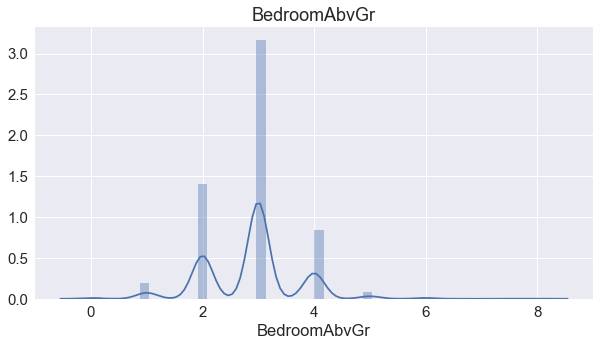

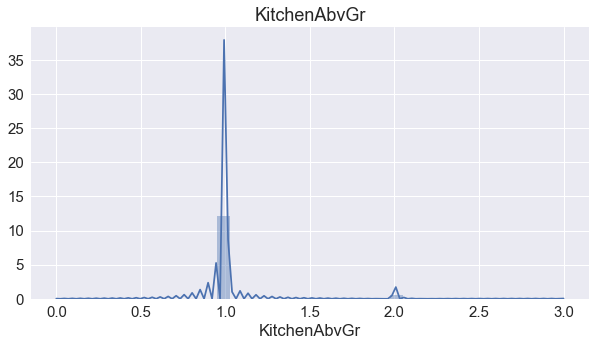

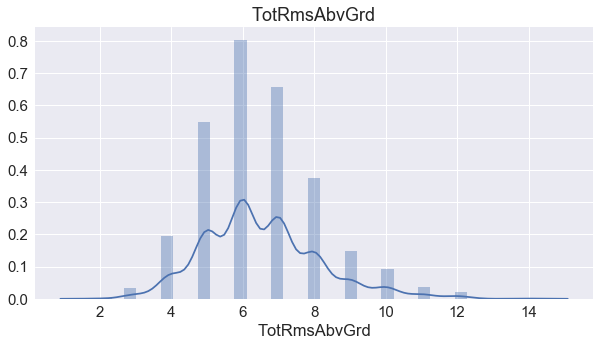

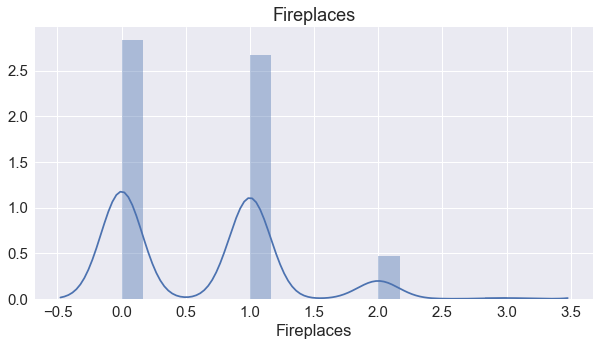

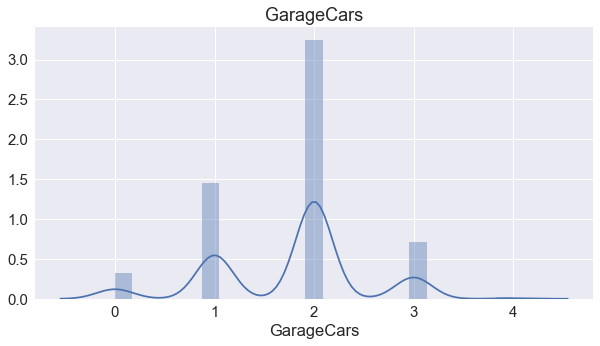

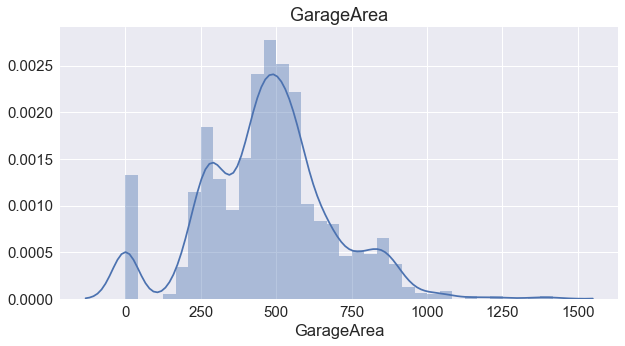

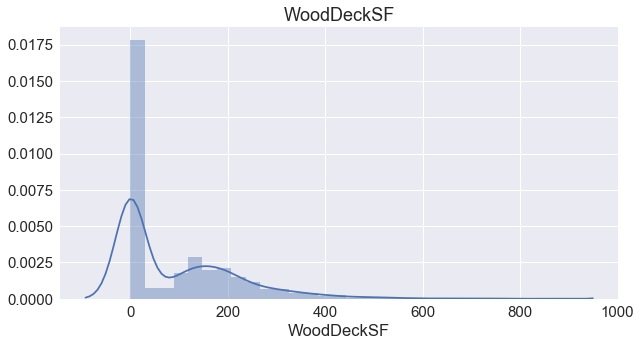

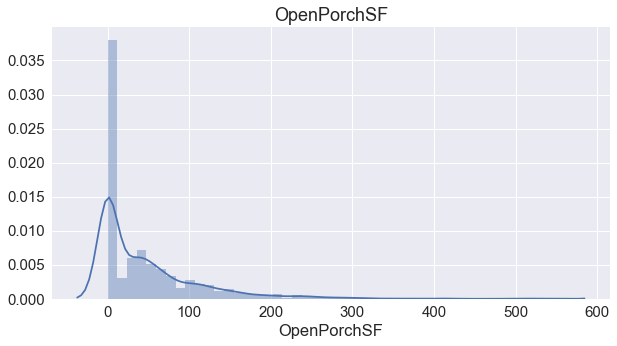

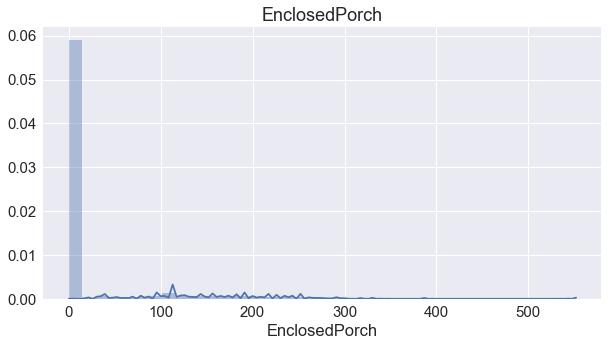

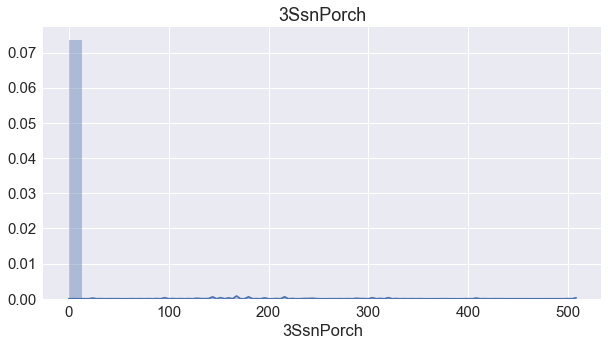

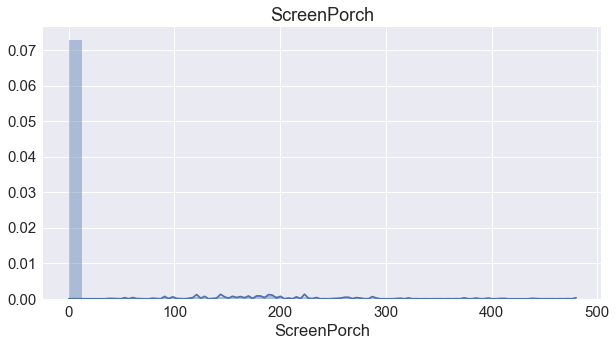

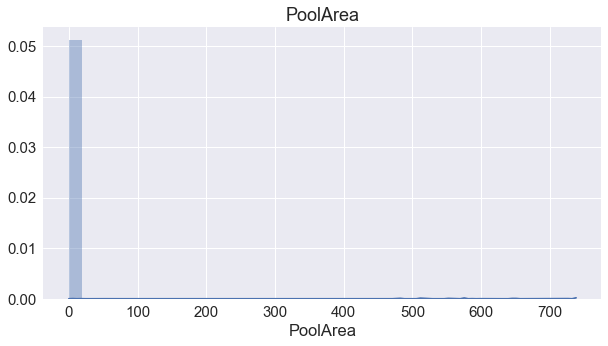

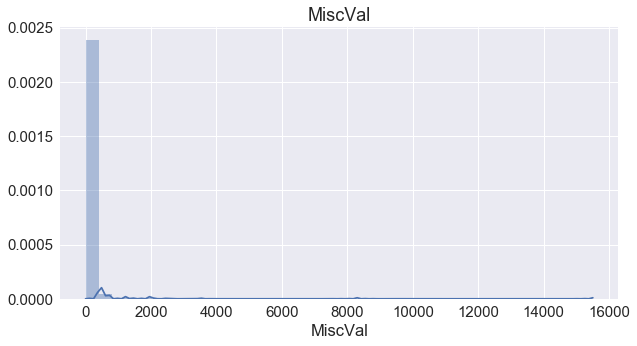

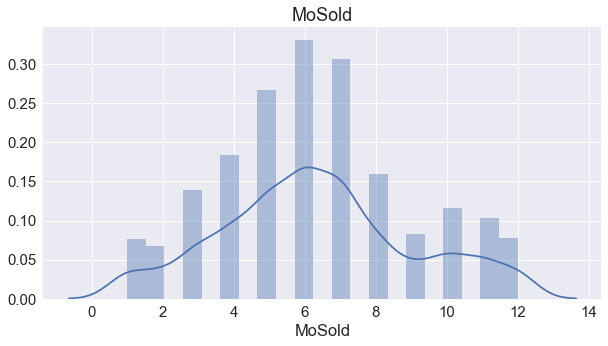

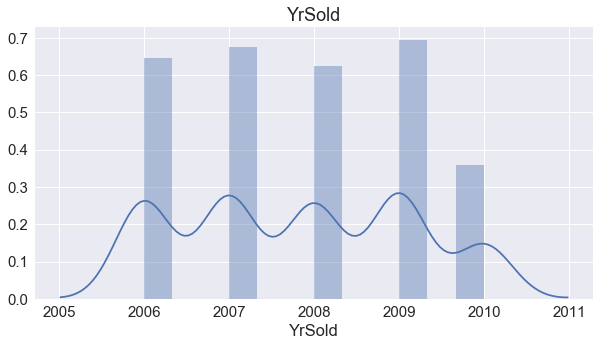

In [62]:
# Graph each of the numerical features
for i in train_data_num:
    plt.figure(figsize=(10, 5)) 
    sns.distplot(train_data_num[i])
    plt.title(i)
    plt.show()

One of these variables, MSSubClass, is actually a categorical variable, but with categories coded by number:

* MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
       
This feature will be converted to a set of binary features using one-shot-encoding

In [63]:
# convert the MSSubClass feature
value_set = set(train_data["MSSubClass"].values)
value_set.remove(list(value_set)[0])

for v in value_set:
    new_col = "MSSubClass" + '_' + str(v)
    train_data[new_col] = train_data["MSSubClass"].map(lambda x: 1.0 if x==v else 0.0)
train_data = train_data.drop("MSSubClass", axis=1)

There is now a total of 176 features. No examples have been removed.

In [64]:
train_data.shape

(1460, 178)

Our last step in the data pre-processing is to split our training dataset into another division of train and test data. This is because the true test dataset provided by Kaggle withholds the labels for the competition; therefore, we consider our train_data to represent the entire dataset available, and further split into train_data_new and test_data.

In [65]:
# Split into train/test features and labels
train_data_new, test_data, train_labels, test_labels = train_test_split(train_data, labels, test_size=0.33, random_state=0)

The shapes of the train and test data are below.

In [66]:
print(train_data_new.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(978, 178)
(482, 178)
(978,)
(482,)


## Prediction Methods

### Random Forest

### A. Feature Selection

While the RandomForest algorithm is very forgiving on a large number of features, outliers and covariates, we first implement some additional feature selection using a base model to get rid of unnecessary features and reduce runtime. The table below ranks the features by descending importance; these weights were calculated by training a base RF model with 100 trees.

In [67]:
# Experiment with feature selection using RandomForest
rfr_feat = RandomForestRegressor(n_estimators = 100, random_state=0)
rfr_feat.fit(train_data_new, train_labels)

importances = {'Feature': list(train_data_new), 'Importance': rfr_feat.feature_importances_}
df_importances = pd.DataFrame(data=importances).sort_values(by =['Importance'], ascending=False)

In [68]:
df_importances

,Feature,Importance
5,OverallQual,5.400462e-01
25,GrLivArea,1.222860e-01
19,TotalBsmtSF,3.683483e-02
16,BsmtFinSF1,3.374019e-02
39,GarageArea,2.962649e-02
38,GarageCars,2.702240e-02
22,1stFlrSF,1.947683e-02
23,2ndFlrSF,1.534244e-02
7,YearBuilt,1.468819e-02
1,LotArea,1.407155e-02


We choose to cut away any feature whose importance is below the mean. Although median is another option, since the feature importances are skewed to a few high-ranking outliers (ex. OverallQuallity), we can reduce the total number of low-ranking features by more using the mean.

In [69]:
print('Mean importance: ', df_importances['Importance'].mean(axis=0))
print('Median importance: ', df_importances['Importance'].median(axis=0))

Mean importance:  0.005617977528089896
Median importance:  0.0002620205839304636


In [70]:
# Create SelectFromModel object that only picks features greater than the median of importances
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rfr_feat, threshold="mean")
sfm.fit(train_data_new, train_labels)
train_data_important = sfm.transform(train_data_new)

We see that the features have been trimmed down substantially by selecting the mean importance as the threshold. This will give improved performance when tuning the hyperparameters.

In [71]:
train_data_important.shape

(978, 16)

### B. Hyperparameter Tuning

Before fitting a Random Forest regressor, we first create a random grid of hyperparameters to traverse. The Random Grid allows us to get a general idea of optimal parameters by randomly selecting combinations from the grid. We can later narrow down the parameter values using a full-factorial combination of parameters in GridSearchCV. While there are more available, we selected to optimize the number of estimators (trees), max depth of each tree, minimum number of samples per split, and minimum number of samples in each leaf node.

In [72]:
# Define number of decision trees to use
n_estimators = [50, 100, 150, 200]

# Define max depth of the tree. Since we have 1460 observations, we must limit the number of splits to try
max_depth = [10, 20, 50, 100]

# Define minimum number of samples required to split a node
min_samples_split = [1.0, 2, 4]

# Define minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

random_grid

{'max_depth': [10, 20, 50, 100],
 'min_samples_leaf': [2, 5, 10],
 'min_samples_split': [1.0, 2, 4],
 'n_estimators': [50, 100, 150, 200]}

We create a RandomForest model and use RandomizedSearchCV to optimize the set of hyperparameters from the random grid. We also specify the randomized search to try 40 combinations with 5-fold cross validation. The 40 combinations are intended to reduce the total number model runs (4 x 5 x 3 x 3) necessary to get an optimal combination; the 5 folds reduce the likelihood of overfitting. These values were chosen due to performance constraints.

In [73]:
# Define the base model
rfr = RandomForestRegressor()

# Fit model
rfr_randomgrid = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 40, 
                                    cv = 5, verbose=1)

rfr_randomgrid.fit(train_data_important, train_labels)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=40, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 50, 100], 'min_samples_split': [1.0, 2, 4], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=1)

We then output the set of best parameters from the random grid search to get an idea of what ranges to use in the full GridSearch.

In [74]:
rfr_randomgrid.best_params_

{'max_depth': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

We create a full grid surrounding the best parameters from the RandomGrid search to fully optimize the combination.

In [75]:
# Define number of decision trees to use
n_estimators = [180, 200, 220]

# Define max depth of the tree
max_depth = [80, 100, 120]

# Define minimum number of samples required to split a node
min_samples_split = [1.0, 2, 3]

# Define minimum number of samples required at each leaf node
min_samples_leaf = [3, 4, 5]

# Create the random grid
full_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

full_grid

{'max_depth': [80, 100, 120],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [1.0, 2, 3],
 'n_estimators': [180, 200, 220]}

 We choose 3 inputs for each parameter, giving us (3 x 3 x 3 x 3)=81 models to run. Since this is still a signficant number, we will reduce the number of folds in the cross-validation from 5 to 3.

In [76]:
# Define the base model
rfr = RandomForestRegressor()

# Fit model
rfr_fullgrid = GridSearchCV(estimator = rfr, param_grid = full_grid,
                                    cv = 3, verbose=1)

rfr_fullgrid.fit(train_data_important, train_labels)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  4.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [180, 200, 220], 'max_depth': [80, 100, 120], 'min_samples_split': [1.0, 2, 3], 'min_samples_leaf': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

Now we can get the best parameters from the GridSearch and set our RandomForest regressor to the best estimator.

In [77]:
print(rfr_fullgrid.best_params_)

{'max_depth': 80, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 180}


In [78]:
rfr_best = rfr_fullgrid.best_estimator_
rfr_best

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=180, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### C. Prediction and Scoring

Now that we have optimized the features and hyperparameters for the Random Forest regressor, we can run the prediction on test data.

First we transform the test data to contain the same features as the reduced train data.

In [79]:
# Transform the test data on the pre-fit sfm
test_data_important = sfm.transform(test_data)

In [80]:
# Predict on test data
test_predict = rfr_best.predict(test_data_important)

# Score the model on r-squared
rfr_r2 = r2_score(test_labels, test_predict)

# Score the model using RMSE
rfr_rmse = np.sqrt(mean_squared_error(test_labels, test_predict))

print('RandomForest r-squared: ', rfr_r2)
print('RandomForest RMSE: ', rfr_rmse)

RandomForest r-squared:  0.836682820617
RandomForest RMSE:  32514.4918846


### LinearRegression

In [ ]:
lr_train_data_num=copy.deepcopy(train_data_num)

In [91]:
lr_labels=labels.to_frame()
print()

(1460, 1)


In [ ]:
lr_train_data_num[['SalePrice']]=

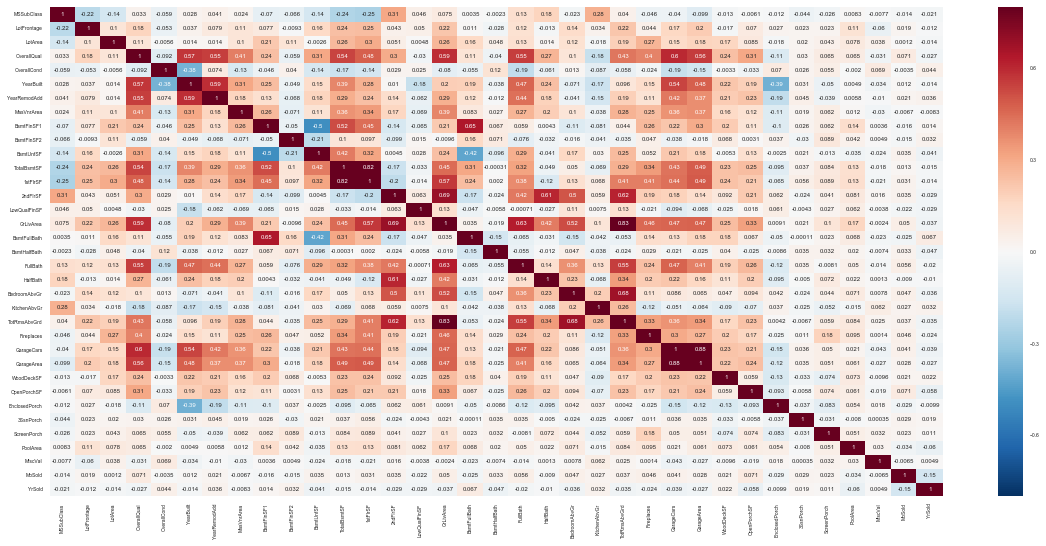

In [82]:
corrmat = train_data_num.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.set(font_scale=0.5)  #
sns.heatmap(corrmat, vmax=.8, annot=True);
plt.show()

In [86]:
# most correlated features
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(30,30))
g = sns.heatmap(train_data_num[top_corr_features].corr(),annot=True,cmap="YlOrRd")

KeyError: 'SalePrice'

(1460, 35)

###NeuralNetwork